In [1]:
!pip install hiddenlayer

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
## 导入相关包
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.manifold import TSNE
import graphviz
import hiddenlayer as hl
#from torchviz import make_dot
import seaborn as sns
import os

In [3]:
#from google.colab import files
#files.download('pytorch_resnet_bloks.pdf')

In [4]:
class WAZIR(nn.Module):
    
    def __init__(self, kernel_size = 3, n_channels = 64):
        super(WAZIR, self).__init__()
                
        # common layer
        self.drop = nn.Dropout(p=0.8)
        self.prelu = nn.PReLU() # nn.PReLU(self.conv1(x)) 방식 이용 불가. 별도 선언.
        
        # feature extraction layer
        self.conv1 = nn.Conv2d(1, 196, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = False)
        self.conv2 = nn.Conv2d(196, 166, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = False)
        #self.conv2 = depthwise_separable_conv()
        self.conv3 = nn.Conv2d(166, 148, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = False)
        self.conv4 = nn.Conv2d(148, 133, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = False)
        self.conv5 = nn.Conv2d(133, 120, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = False)
        self.conv6 = nn.Conv2d(120, 108, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = False)
        self.conv7 = nn.Conv2d(108, 97, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = False)
        self.conv8 = nn.Conv2d(97, 86, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = False)
        self.conv9 = nn.Conv2d(86, 76, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = False)
        self.conv10 = nn.Conv2d(76, 66, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = False)
        self.conv11 = nn.Conv2d(66, 57, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = False)
        self.conv12 = nn.Conv2d(57, 48, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = False)
        
        ## he initialization
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.kaiming_normal_(self.conv4.weight)
        nn.init.kaiming_normal_(self.conv5.weight)
        nn.init.kaiming_normal_(self.conv6.weight)
        nn.init.kaiming_normal_(self.conv7.weight)
        nn.init.kaiming_normal_(self.conv8.weight)
        nn.init.kaiming_normal_(self.conv9.weight)
        nn.init.kaiming_normal_(self.conv10.weight)
        nn.init.kaiming_normal_(self.conv11.weight)
        nn.init.kaiming_normal_(self.conv12.weight)
        
        # reconstruction layer
        self.A1 = nn.Conv2d(1301, 64, 1, stride = 1, bias = False)
        self.B1 = nn.Conv2d(1301, 32, 1, stride = 1, bias = False)
        self.B2 = nn.Conv2d(32, 32, kernel_size, stride = 1, padding=1,padding_mode="replicate",bias=False)
        
        ## he initialization
        nn.init.kaiming_normal_(self.A1.weight)
        nn.init.kaiming_normal_(self.B1.weight)
        nn.init.kaiming_normal_(self.B2.weight)
        
        # feature extraction layer
        self.UPsample = nn.Conv2d(96, 2*2*96, kernel_size, stride = 1, padding =1, padding_mode = "replicate", bias = False)
        self.pixelshuffle = nn.PixelShuffle(2)
        
        self.R = nn.Conv2d(96, 1, kernel_size, stride = 1, padding = 1, padding_mode = "replicate", bias = False)
        
        ## he initialization
        nn.init.kaiming_normal_(self.UPsample.weight)
        nn.init.kaiming_normal_(self.R.weight)
        
    def forward(self, x):
                
        # feature extraction network
        skip1 = self.drop(self.prelu(self.conv1(x)))
        skip2 = self.drop(self.prelu(self.conv2(skip1)))
        skip3 = self.drop(self.prelu(self.conv3(skip2)))
        skip4 = self.drop(self.prelu(self.conv4(skip3)))
        skip5 = self.drop(self.prelu(self.conv5(skip4)))
        skip6 = self.drop(self.prelu(self.conv6(skip5)))
        skip7 = self.drop(self.prelu(self.conv7(skip6)))
        skip8 = self.drop(self.prelu(self.conv8(skip7)))
        skip9 = self.drop(self.prelu(self.conv9(skip8)))
        skip10 = self.drop(self.prelu(self.conv10(skip9)))
        skip11 = self.drop(self.prelu(self.conv11(skip10)))
        skip12 = self.drop(self.prelu(self.conv12(skip11)))
        
        # reconstruction network
        recon_input = torch.cat([skip1, skip2, skip3, skip4, skip5, skip6, skip7, skip8, skip9, skip10, skip11, skip12], dim = 1)
        
        A1_out = self.drop(self.prelu(self.A1(recon_input)))
        
        B1_out = self.drop(self.prelu(self.B1(recon_input)))
        B2_out = self.drop(self.prelu(self.B2(B1_out)))
        
        recon_output = torch.cat([A1_out, B2_out], dim = 1)
        
        # up-sampling network
        UPsample_out = self.drop(self.pixelshuffle(self.UPsample(recon_output)))
        R_out = self.R(UPsample_out)
        
        return R_out

model = WAZIR()
print(model)

WAZIR(
  (drop): Dropout(p=0.8, inplace=False)
  (prelu): PReLU(num_parameters=1)
  (conv1): Conv2d(1, 196, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=replicate)
  (conv2): Conv2d(196, 166, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=replicate)
  (conv3): Conv2d(166, 148, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=replicate)
  (conv4): Conv2d(148, 133, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=replicate)
  (conv5): Conv2d(133, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=replicate)
  (conv6): Conv2d(120, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=replicate)
  (conv7): Conv2d(108, 97, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=replicate)
  (conv8): Conv2d(97, 86, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=replicate)
  (

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:1630: UserWarning: Dropout is a training op and should not be exported in inference mode. For inference, make sure to call eval() on the model and to export it with param training=False.
  warnings.warn("Dropout is a training op and should not be exported in inference mode. "


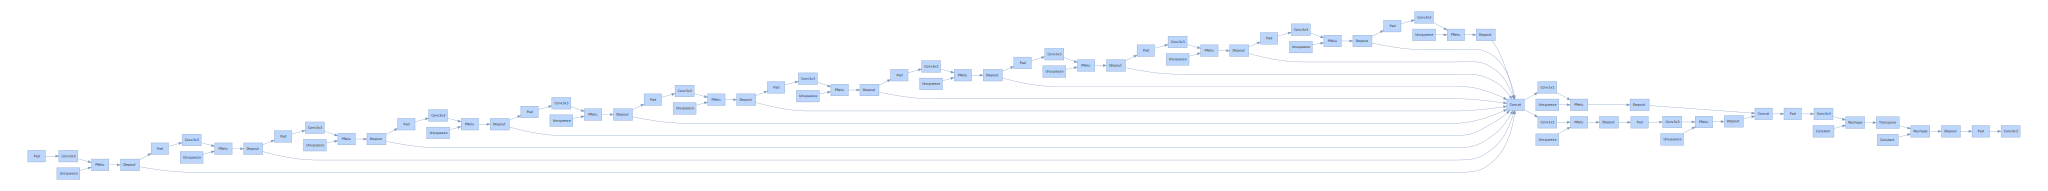

In [5]:
hl_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]))
hl_graph.theme = hl.graph.THEMES["blue"].copy()  
hl_graph

In [6]:
hl_graph.theme = hl.graph.THEMES["blue"].copy()
hl_graph.save(os.path.join("", "DCSCN.pdf"))

In [7]:
#from google.colab import files
#files.download('DCSCN.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>